<a href="https://colab.research.google.com/github/codefupanda/kaggle-projects/blob/master/Melonoma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs, Utils, Configurations, etc

In [ ]:
pip install -U efficientnet

Requirement already up-to-date: efficientnet in /usr/local/lib/python3.6/dist-packages (1.1.0)


## Imports

In [ ]:
# The basics
import numpy as np
import pandas as pd

# Some plotting
import plotly.graph_objects as go
import plotly.express as px

#sklear
import sklearn
from sklearn import model_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

## Keras
import tensorflow as tf
from tensorflow.keras import metrics
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet152V2

# efficientnet
import efficientnet.tfkeras as efn 

# Etc
import os
import gc
import shutil
import collections
import psutil
import glob

## Utils

In [ ]:
def gdrive_mount():
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)

In [ ]:
def is_gpu():
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    return False
  print('Found GPU at: {}'.format(device_name))
  return True

In [ ]:
def tf_init():
  tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})

In [ ]:
class Kaggle:

  def __init__(self, competition_name=None, dataset_name=None, kaggle_config_dir='/content/gdrive/My Drive/Colab Notebooks/.kaggle', base_folder='/tmp'):
    if competition_name:
      self.name = competition_name
      self.competition = True
    if dataset_name:
      self.name = dataset_name
      self.dataset = True 
    self.kaggle_config_dir = kaggle_config_dir
    self.base_folder = base_folder
    self.path = os.path.join(self.base_folder, self.name)
    os.environ['KAGGLE_CONFIG_DIR'] = kaggle_config_dir

  def download(self):
    if self.dataset:
      return os.system('kaggle datasets download -d ' + self.name + ' -p ' + self.path)
    return os.system('kaggle competitions download -c ' + self.name + ' -p ' + self.path)

  def download_file(self, file_name, sub_folder=''):
    if self.dataset:
      return os.system('kaggle datasets download -d ' + self.name + ' -p ' + os.path.join(self.path, sub_folder) + ' -f ' + file_name)
    return os.system('kaggle competitions download -c ' + self.name + ' -p ' + os.path.join(self.path, sub_folder) + ' -f ' + file_name)

  def show_files(self):
    return print(self.get_files())

  def get_files(self, sub_folder=''):
    return [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.join(self.path, sub_folder)) for f in fn]

  def show_dirs(self):
    return print(self.get_dirs())

  def get_dirs(self):
    return [ name for name in os.listdir(self.path) if os.path.isdir(os.path.join(self.path, name)) ]

  def unzip(self):
    return os.system('find ' + self.path + ' -name "*.zip" | xargs -P 5 -I fileName sh -c \'unzip -o -d "$(dirname "fileName")" "fileName"\'')

  def clean_folder(self, file_extension='.zip'):
    for f1le in self.get_files():
      if f1le.endswith(file_extension):
        os.remove(f1le)

  def reset_folder(self):
    shutil.rmtree(self.path)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn import model_selection

class EnsembleImageClassifier:

  METRICS = [
    metrics.TruePositives(name='tp'),
    metrics.FalsePositives(name='fp'),
    metrics.TrueNegatives(name='tn'),
    metrics.FalseNegatives(name='fn'), 
    metrics.BinaryAccuracy(name='accuracy'),
    metrics.Precision(name='precision'),
    metrics.Recall(name='recall'),
    metrics.AUC(name='auc'),
  ]

  def __init__(self, base_folder, model_def, k_folds=None, batch_size=1024, workers=10, metrics=None, image_shape=(256, 256, 3), completion_callback=None, lr=None):
    self.base_folder = base_folder
    self.train_folder = os.path.join(base_folder, 'train')
    self.test_folder = os.path.join(base_folder, 'test')
    self.models_folder = os.path.join(base_folder, 'models')
    self.batch_size = batch_size
    self.metrics = metrics or EnsembleImageClassifier.METRICS
    self.results = list()
    self.image_shape = image_shape
    self.completion_callback = completion_callback
    self.workers = workers
    self.models = self.get_models(base_folder, model_def, k_folds, lr)

  def get_models(self, base_folder, model_def, k_folds, lr):
    models = []
    if os.path.isdir(self.models_folder) and glob.glob(self.models_folder + '/*.h5'):
      models_path = glob.glob(self.models_folder + '/*.h5')
      models = [load_model(model_path) for model_path in models_path]
    else:
      if isinstance(model_def, collections.Iterable):
        if callable(model_def[0]):
          models = [model_def_() for model_def_ in model_def]
        else:
          models = model_def
      else:
        if callable(model_def):
          k_folds = k_folds or 1
          models = [model_def() for i in range(k_folds)]
        else:
          models = [model_def]
    if lr:
      for model in models:
        K.set_value(model.optimizer.learning_rate, lr) 
    return models


  def fit(self, train_df, epochs, class_weight=None, validate=True, shuffle=True, callbacks=None):

    train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, fill_mode='nearest', height_shift_range=0.2, zoom_range=0.2, horizontal_flip=True, vertical_flip=True)

    if class_weight is None:
      class_weight_array = compute_class_weight('balanced', np.unique(train_df['target']), train_df['target'])
      class_weight = {i : class_weight_array[i] for i in range(len(class_weight_array))}
      print('computed class weights ' + str(class_weight))

    splits = self.split_data(train_df)

    for i, (model, (train_df, test_df)) in enumerate(zip(self.models, splits)):
      print(len(train_df))
      fit_params = {
          'steps_per_epoch': len(train_df)//self.batch_size,
          'epochs': epochs,
          'class_weight': class_weight,
          'workers': self.workers
      }
      model_file_path = os.path.join(self.models_folder, str(i) + ".h5")
      fit_params['callbacks'] = [tf.keras.callbacks.ModelCheckpoint(model_file_path, verbose=1, save_freq='epoch')]
      if callbacks:
        fit_params['callbacks'].append(callbacks)
        
      if validate:
        test_generator = train_datagen.flow_from_dataframe(test_df, 
                                                        x_col="image_id_ext",
                                                        y_col="target",
                                                        directory=self.base_folder + '/train/', 
                                                        target_size=self.image_shape[0:2], 
                                                        batch_size=self.batch_size,
                                                        class_mode='raw',
                                                        validate_filenames=False,
                                                        shuffle=False)
        fit_params['validation_data'] = test_generator,
        fit_params['validation_steps'] = len(test_df)//self.batch_size

      train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                      x_col="image_id_ext",
                                                      y_col="target",
                                                      directory=self.base_folder + '/train/', 
                                                      target_size=self.image_shape[0:2], 
                                                      batch_size=self.batch_size,
                                                      class_mode='raw',
                                                      validate_filenames=False,)

      history = model.fit(train_generator, **fit_params)
      self.results.append({'model': model, 'history': history})
      if self.completion_callback:
        self.completion_callback({'model': model, 'history': history})
      self.reset_mem()
    return self.results

  def split_data(self, train_df):
    splits = []
    if len(self.models) > 1:
      sfk = StratifiedKFold(n_splits=len(self.models), shuffle=shuffle)
      splits = [(train_df.iloc[train_index], train_df.iloc[test_index]) for train_index, test_index in sfk.split(train_df['image_id_ext'], train_df['target'])]
    else:
      x_train, x_test, y_train, y_test = train_test_split(train_df['image_id_ext'], train_df['target'], test_size=0.2, random_state=0, stratify=train_df['target'])
      splits = [(pd.DataFrame({"image_id_ext": x_train, 'target': y_train}), pd.DataFrame({"image_id_ext": x_test, 'target': y_test}))]
    return splits
    
  def reset_mem(self):
    #process = psutil.Process(os.getpid())
    #print(process.memory_info()[0])
    K.clear_session()
    print(gc.collect())
    #print(process.memory_info()[0])


  def predict(self, test_df, batch_size):
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(test_df, 
                                                      x_col="image_id_ext",
                                                      y_col="target",
                                                      directory=self.base_folder + '/test/', 
                                                      target_size=self.image_shape[0:2], 
                                                      batch_size=batch_size,
                                                      class_mode='raw',
                                                      validate_filenames=False,
                                                      shuffle=False)
    probs = np.zeros(len(test_df))
    for model in self.models:
        model_probs = model.predict_generator(test_generator, len(test_df)//batch_size, verbose=1)
        probs = probs + model_probs.reshape(len(test_df))

    return probs / len(self.models)



In [ ]:
# https://github.com/umbertogriffo/focal-loss-keras/blob/master/losses.py
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = tf.keras.backend.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = tf.keras.backend.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = tf.keras.backend.clip(pt_0, epsilon, 1. - epsilon)

        return -tf.keras.backend.mean(alpha * tf.keras.backend.pow(1. - pt_1, gamma) * tf.keras.backend.log(pt_1)) \
               -tf.keras.backend.mean((1 - alpha) * tf.keras.backend.pow(pt_0, gamma) * tf.keras.backend.log(1. - pt_0))

    return binary_focal_loss_fixed

## Define Constants

In [ ]:
EPOCHS=5
DOWN_SAMPLE=False
BATCH_SIZE=256
SAMPLE_SIZE=BATCH_SIZE * 10

## Setup the environment

In [ ]:
gdrive_mount()
tf_init()

Mounted at /content/gdrive


## Download data

In [ ]:
kaggle = Kaggle(dataset_name='shonenkov/melanoma-merged-external-data-512x512-jpeg')

In [ ]:
kaggle.download()
kaggle.unzip()
kaggle.clean_folder()

kaggle datasets download -d shonenkov/melanoma-merged-external-data-512x512-jpeg -p /tmp/shonenkov/melanoma-merged-external-data-512x512-jpeg


In [ ]:
kaggle.get_dirs()

['512x512-dataset-melanoma', 'train', 'test', 'models', '512x512-test']

In [ ]:
!mkdir '/tmp/shonenkov/melanoma-merged-external-data-512x512-jpeg/train'
!mkdir '/tmp/shonenkov/melanoma-merged-external-data-512x512-jpeg/test'

In [ ]:
!find /tmp/shonenkov/melanoma-merged-external-data-512x512-jpeg/512x512-dataset-melanoma/512x512-dataset-melanoma/ -type f -print0 | xargs -0 mv -t /tmp/shonenkov/melanoma-merged-external-data-512x512-jpeg/train/

In [ ]:
!mv /tmp/shonenkov/melanoma-merged-external-data-512x512-jpeg/512x512-test/512x512-test/* /tmp/shonenkov/melanoma-merged-external-data-512x512-jpeg/test

Point the "models" dir to drive, where we want to keep saving the models

In [ ]:
!ln -s "/content/gdrive/My Drive/Colab Notebooks/.kaggle/siim-isic-melanoma-classification/models" /tmp/shonenkov/melanoma-merged-external-data-512x512-jpeg/models

In [ ]:
train_df = pd.read_csv(os.path.join(kaggle.path, 'marking.csv'))
train_df['image_id_ext'] = train_df['image_id'] + '.jpg'

In [ ]:
original_train_df = train_df
train_df.shape, train_df[train_df['target'] == 1].shape, train_df[train_df['target'] == 0].shape 

((60487, 8), (5479, 8), (55008, 8))

down-sample

In [ ]:
if DOWN_SAMPLE:
  print('Down sampling negative category')
  train_df = pd.concat([original_train_df[original_train_df['target'] == 1], original_train_df[original_train_df['target'] == 0].sample(len(original_train_df[original_train_df['target'] == 1]))])

Take sample

In [ ]:
if SAMPLE_SIZE:
  print('Taking a sample of size ' + str(SAMPLE_SIZE))
  train_df = train_df.sample(SAMPLE_SIZE)
  len(train_df[train_df['target'] == 1])

Taking a sample of size 2560


## Define models

In [ ]:
def model_def1():
  print('creating model model_def1')
  optim = optimizers.Adam(lr=1e-3)

  conv_base = efn.EfficientNetB6(weights='imagenet', include_top=False, input_shape=(256, 256, 3), pooling='avg')
  conv_base.trainable = False
  
  for layer in conv_base.layers:
    layer.trainable = False
  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.05), optimizer=optim, metrics=EnsembleImageClassifier.METRICS)
  return model

In [ ]:
def model_def2():
  print('creating model model_def2')
  optim = optimizers.Adam(lr=1e-3)

  conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
  conv_base.trainable = False
  
  for layer in conv_base.layers:
    layer.trainable = False
  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=optim, metrics=EnsembleImageClassifier.METRICS)
  return model

In [ ]:
def model_def3():
  print('creating model model_def3')
  optim = optimizers.Adam(lr=1e-3)

  conv_base = ResNet152V2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
  conv_base.trainable = False
  
  for layer in conv_base.layers:
    layer.trainable = False
  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=optim, metrics=EnsembleImageClassifier.METRICS)
  return model

# Train the models

In [ ]:
classifier = EnsembleImageClassifier(kaggle.path, model_def1, batch_size=BATCH_SIZE, lr=0.01)

creating model model_def1


In [ ]:
gc.collect()

339

In [ ]:
result = classifier.fit(train_df, EPOCHS, validate=True, shuffle=False, class_weight={0: 1, 1: 1})

48389
Found 12098 non-validated image filenames.
Found 48389 non-validated image filenames.
Epoch 1/5
182/189 [===========================>..] - ETA: 29s - loss: 0.3068 - tp: 766.0000 - fp: 597.0000 - tn: 41559.0000 - fn: 3419.0000 - accuracy: 0.9133 - precision: 0.5620 - recall: 0.1830 - auc: 0.8091

# Test

In [ ]:
test_images = kaggle.get_files('test')

In [ ]:
test_image_ext = [os.path.split(test_image)[1] for test_image in test_images]

In [ ]:
test_df = pd.DataFrame({'image_id_ext': test_image_ext})

In [ ]:
len(test_df)

10982

In [ ]:
test_df['target'] = 0

In [ ]:
test_df.head()

,image_id_ext,target
0,ISIC_3798140.jpg,0
1,ISIC_9685762.jpg,0
2,ISIC_8760303.jpg,0
3,ISIC_3612582.jpg,0
4,ISIC_8370736.jpg,0


In [ ]:
# probs = classifier.test(test_df, 38)

In [ ]:
probs = np.zeros(len(test_df))

In [ ]:
ttl = 4

In [ ]:
for ttl in range(ttl):
  test_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, fill_mode='nearest', height_shift_range=0.2, zoom_range=0.2, horizontal_flip=True, vertical_flip=True)
  test_generator = test_datagen.flow_from_dataframe(test_df, 
                                                    x_col="image_id_ext",
                                                    y_col="target",
                                                    directory=classifier.base_folder + '/test/', 
                                                    target_size=classifier.image_shape[0:2], 
                                                    batch_size=38,
                                                    class_mode='raw',
                                                    validate_filenames=False,
                                                    shuffle=False)

  for model in classifier.models:
    model_probs = model.predict(test_generator, len(test_df)//38, verbose=1, workers=10)
    probs = probs + model_probs.reshape(len(test_df))

  probs = probs / len(classifier.models)

Found 10982 non-validated image filenames.
289/289 [==============================] - 182s 629ms/step
Found 10982 non-validated image filenames.
289/289 [==============================] - 183s 632ms/step


In [ ]:
len(probs[probs/2 > 0.5])

43

In [ ]:
test_df['target'] = probs / 2

In [ ]:
test_df['image_name'] = [sds[0] for sds in test_df['image_id_ext'].str.split(".")]

In [ ]:
test_df[['image_name', 'target']].to_csv('/content/gdrive/My Drive/Colab Notebooks/.kaggle/siim-isic-melanoma-classification/revisit_final_ensemble_result.csv', index=False)

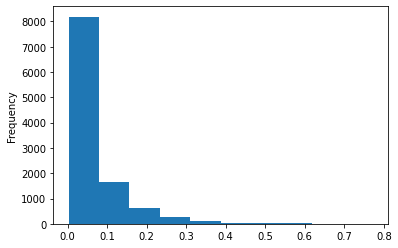

In [ ]:
test_df['target'].plot.hist(10)

In [ ]:
from google.colab import files
files.download('/content/gdrive/My Drive/Colab Notebooks/.kaggle/siim-isic-melanoma-classification/revisit_final_ensemble_result.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>